# Economic Data Analysis With Pandas & FRED API
Place the following notice prominently on your application: "This product uses the FRED® API but is not endorsed or certified by the Federal Reserve Bank of St. Louis." 

**In order for the FRED API to work, you are going to need an API KEY, you can obtain one on the FRED [website](https://fred.stlouisfed.org/) or if you don't want to register can send me a message to give you mine**

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred


from use_key import get_api_key


plt.style.use("fivethirtyeight")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fred_key = get_api_key()

# 1. Create the FRED object
<br>
By instantiating the Fred class passing your personal API key as an argument

Two things that FRED allows us to do is:
* Search for economic data - so you can check if they have what you need
* Pull the economic data - so you can perform operations with it


In [371]:
fred = Fred(api_key=fred_key)

# 2.1 Search for economic data from FRED database.

In [431]:
sp_search = fred.search('S&P', order_by='popularity')

In [434]:
sp_search.head()    # Gives us the first 5 results
sp_search.tail()    # Gives us the last 5 results
sp_search.shape     # Gives us the Rows and Cols of the data

(1000, 15)

# 2.2 Pull Raw Data


In [374]:
sp500 = fred.get_series(series_id='SP500', observation_start='2020-12-01', observation_end='2023-12-01')

# 2.3 Basic plot the raw data
### Pandas supports matplotlib basic functionalities to visualise charts
You can use **kwargs to pass styling to the graphs
``` figsize=(float, float) # To change the figure size ```
``` title = string  # To add a title to the graph ```
``` lw = float # To change the line width```
A bit more info on this [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

<Axes: title={'center': 'S&P 500'}>

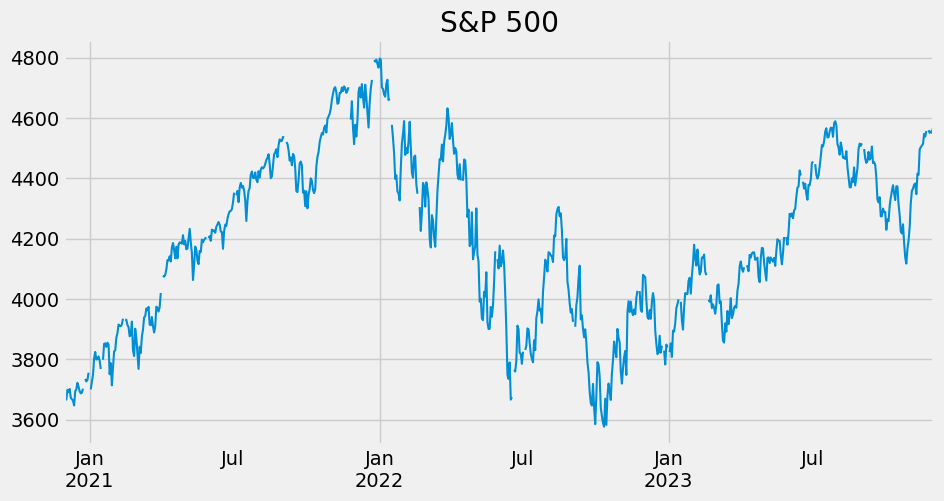

In [375]:
sp500.plot(figsize=(10, 5), title='S&P 500', lw=1.5)

# 3. Pull and Join Multiple Data Series
When you get a Panda dataframe you can use 
**df_name.query('{query here}') to advance filter the search results**
<br>
**To look at any of the columns content you can specify the df_name and use the title as in a dictionary**
```df_name['title']```
*this code will give us all the rows with the info from that column*

In [376]:
unemployment_res = fred.search('unemployment')
unemployment_rates = fred.get_series(series_id='UNRATE')

<Axes: >

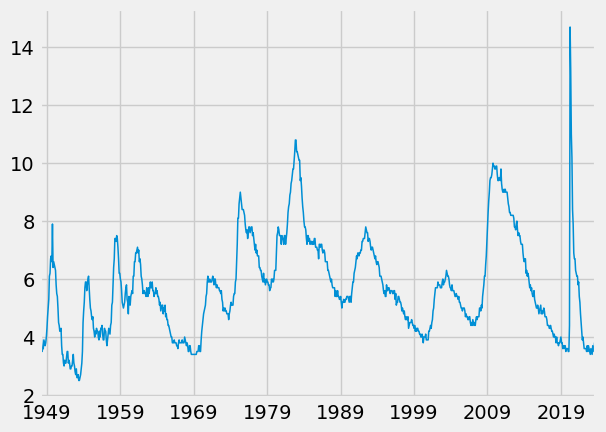

In [377]:
unemployment_rates.plot(lw=1.1)

In [378]:
# Get the unemployment data by month
unra_monthly_df = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))
unra_monthly_df = unra_monthly_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unra_monthly_df = unra_monthly_df.loc[unra_monthly_df['title'].str.contains('Unemployment Rate in')]

***Now that we have filtered the results that we need, we will get all the different series, by looping through the dataframe index, and pulling them out by index, then we will store all the results in a list variable so we can use them for plotting later on***

***We use the ``` result.to_frame(name=myid) ``` so we can convert the series to dataframe with the column name myid***

In [379]:
# unra_monthly_df.index

data_results = []

for myid in unra_monthly_df.index:
    if 'LASMT' not in myid:
        result = fred.get_series(series_id=myid)
        result = result.to_frame(name=myid)
        data_results.append(result)
unra_by_state = pd.concat(data_results, axis=1).drop(columns=['CMATUR', 'CNEWUR', 'CMWRUR', 'CWSTUR', 'CSOUUR', 'CNERUR' ])


* ***Now we will take all those dataframes that are separate in the list and concatenate them together, so they will form one dataframe with columns for each dataframe separately. <br> In this case we will use the <br><br>```pd.concat(data_results, axis=1)```***

In [380]:
unra_by_state = unra_by_state.dropna()  # Dropping all the N/A values 

# Rename Columns to Actual State Names
**Create a dictionary to store the index values of the series and their actual state names from the initial dataframe, and then map the column titles of the unra_by_state dataframe to the actual State Name**

In [381]:
idx_name_map = unra_monthly_df.title.str.replace('Unemployment Rate in', '').to_dict()
unra_by_state.columns = [idx_name_map[col] for col in unra_by_state.columns if col in idx_name_map]

# Plot states Unemployment Rate
**We will use the plotly.express to plot all the data from the dataframe**

In [382]:
px.line(unra_by_state)

# 4. Pull May 2020 Unemployment Rate Per State

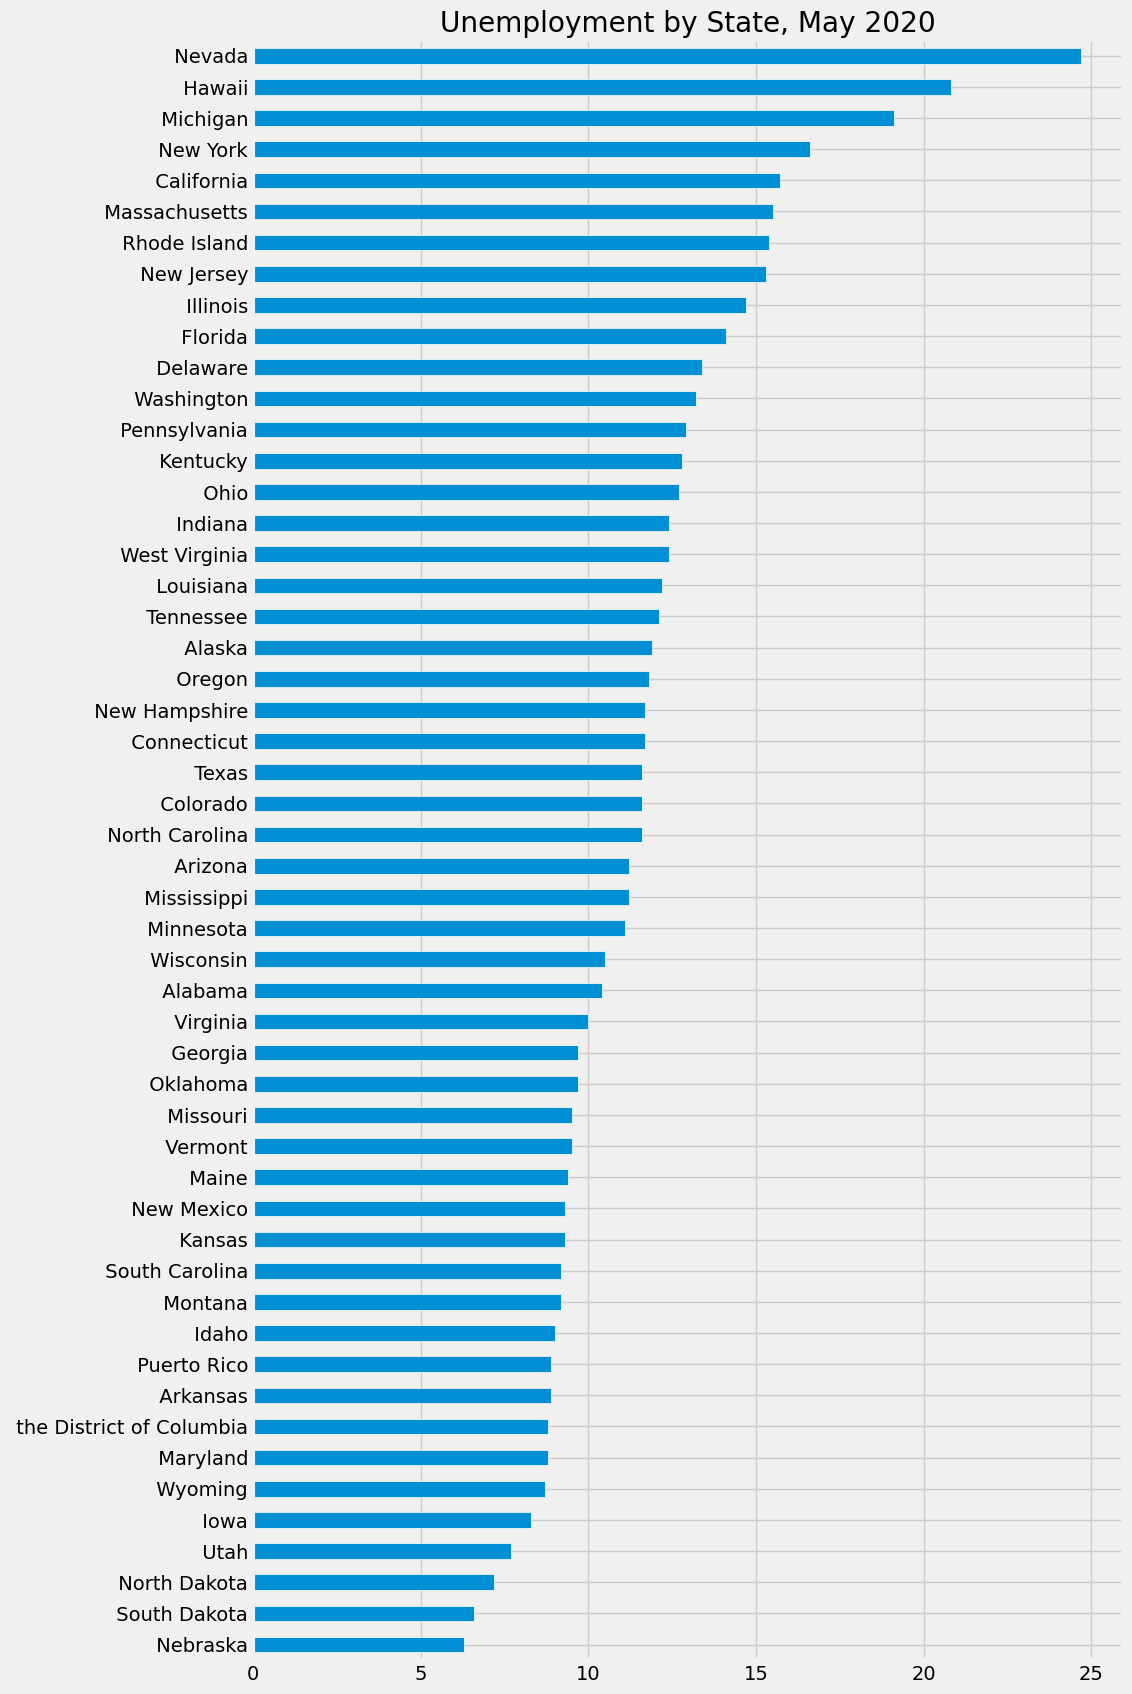

In [383]:
april_2020_unra = unra_by_state.loc[unra_by_state.index == '2020-05-01'].T.sort_values('2020-05-01')
# Plotting using the plotly
px.bar(april_2020_unra, orientation='h')

# Plotting with the pandas default plotting engine
april_2020_unra.plot(kind='barh', figsize=(10, 20),edgecolor='white', title='Unemployment by State, May 2020').legend().remove()


# 5. Pull Participation Rate

#### Steps:
1. Search the FRED API and filter the result
2. Further filter the result to contain Participation Rates for each State
3. Create a dict with series id and the name of the state
4. Create a list to store all the result we are going to pull from FRED
5. Iterate over the indexes of the searched and filtered results
6. Get the series from FRED and convert them to a DataFrame
7. Add a column name, that will be equal to the mapped value of the index in the dict we created previously
8. Append the result to the list
9. Concatenate using pandas all the results into one DataFrame
10. Plot the results into a graph


In [384]:
part_df = fred.search('participation rate by state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df[part_df['title'].str.contains("Labor Force Participation Rate for")]
part_id_to_state = part_df['title'].str.replace("Labor Force Participation Rate for", "").to_dict()

part_results = []

for myid in part_df.index:
    result = fred.get_series(series_id=myid)
    state_name = myid
    if myid in part_id_to_state:
        state_name = part_id_to_state[myid]
    result = result.to_frame(name=state_name)   # Convert the gotten series to dataframe
    part_results.append(result)


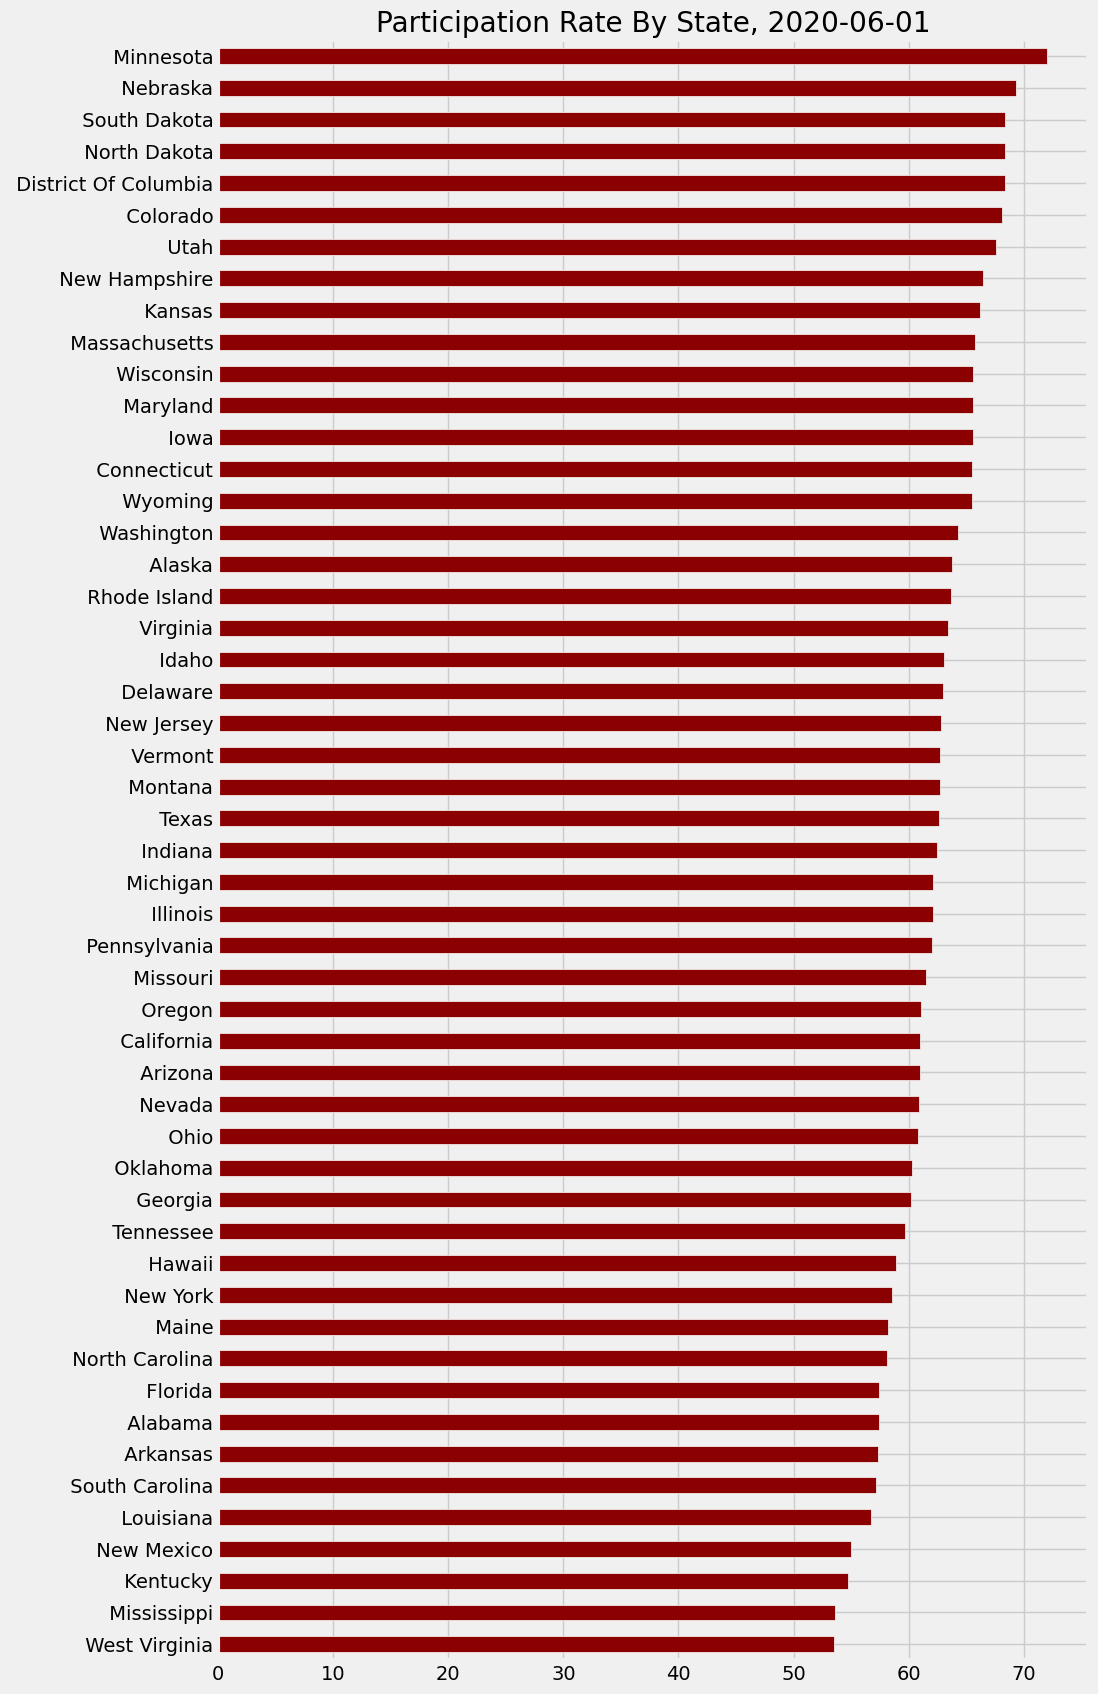

In [385]:
part_results_by_state = pd.concat(part_results, axis=1)
part_results_by_state = part_results_by_state.loc[part_results_by_state.index == '2020-06-01'].T.sort_values('2020-06-01')
part_results_by_state.plot(kind='barh', figsize=(10, 20), edgecolor='white', title='Participation Rate By State, 2020-06-01', color='darkred').legend().remove()

# 6. Plot Participation Rate vs Unemployment Rate

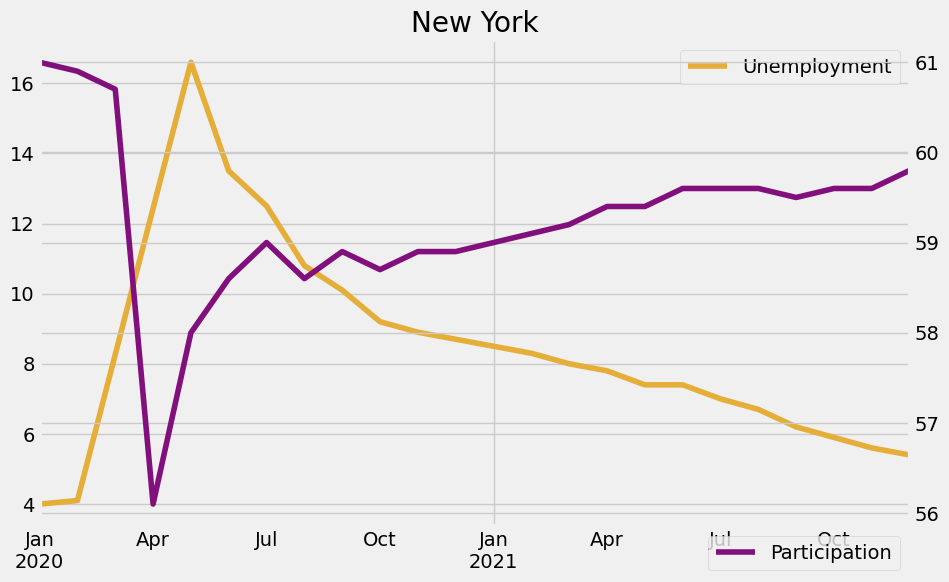

In [388]:
part_results = pd.concat(part_results, axis=1)

fig, ax = plt.subplots(figsize = (10, 6))
ax2 = ax.twinx()
# ax.set_title('Participation vs Unemployment Chart')
part_results.query('index >= 2020 and index < 2022')[' New York'].plot(ax=ax2, color=color_pal[5], label='Participation')
unra_by_state.query('index >= 2020 and index < 2022')[' New York'].plot(ax=ax, label='Unemployment', color=color_pal[2])

ax.set_title('New York')
ax.legend()
ax2.legend(bbox_to_anchor=(1,0))


In [430]:
# Fix the bad formatting on the col names

unra_by_state.columns = [col.strip().replace('the', '') for col in unra_by_state.columns]
part_results.columns = [col.strip() for col in part_results.columns]
unra_by_state = unra_by_state.drop(columns=['Puerto Rico', 'District of Columbia'])

TypeError: 'Index' object is not callable

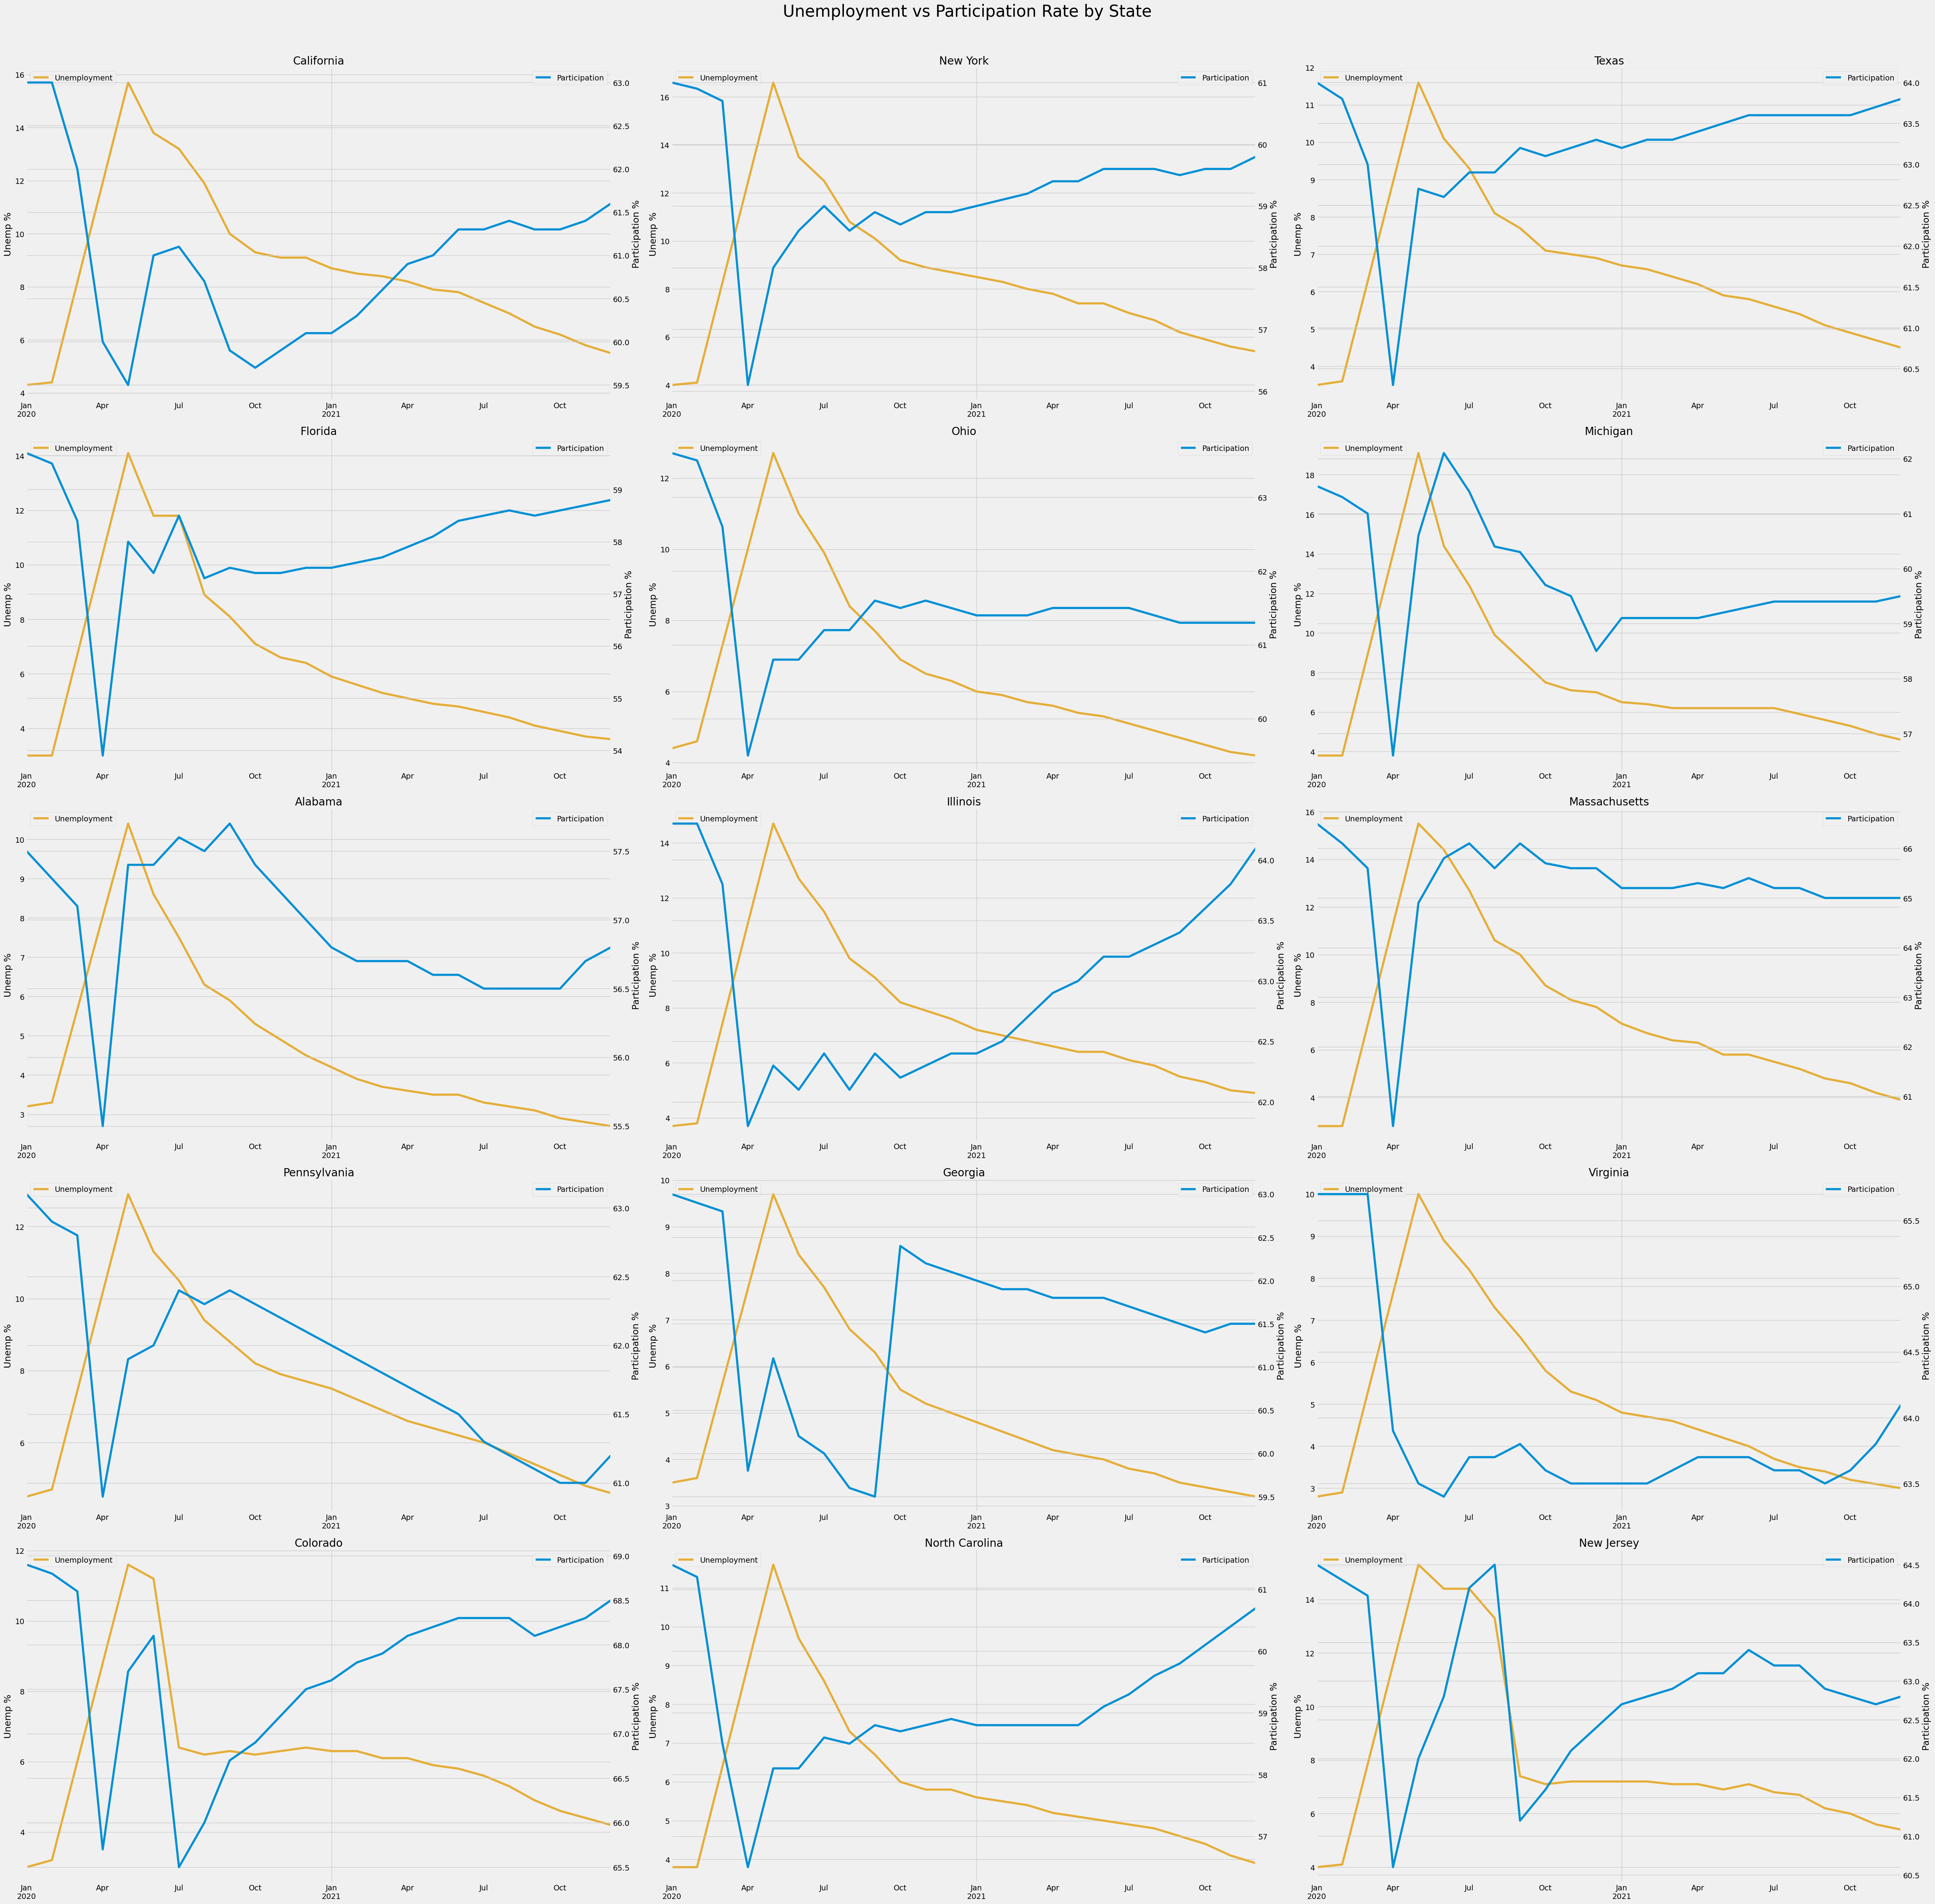

In [422]:
fig2, axs = plt.subplots(5, 3, figsize=(50, 50))
axs = axs.flatten()
i = 0
fig2.suptitle('Unemployment vs Participation Rate by State', fontsize=30)
for state in unra_by_state.columns:
    ax3 = axs[i].twinx()
    # ax.set_title('Participation vs Unemployment Chart')
    part_results.query('index >= 2020 and index < 2022')[state].plot(ax=ax3, label='Participation')
    unra_by_state.query('index >= 2020 and index < 2022')[state].plot(ax=axs[i], label='Unemployment', color=color_pal[2])

    ax3.set_title(state)
    ax3.set_ylabel('Participation %')
    axs[i].legend(loc='upper left')
    axs[i].set_ylabel('Unemp %')
    ax3.legend(loc='upper right')
    plt.tight_layout()
    i += 1
    if i > 14:
        break
        
plt.tight_layout(rect=(0, 0, 1, 0.97))

plt.show()
